## EMI Prediction Project

**Problem Description**

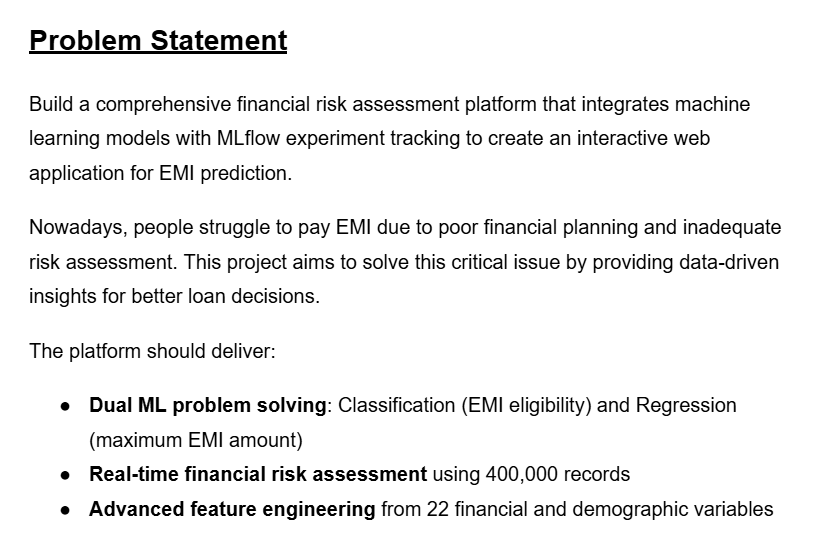

**Objectives**



*   Preprocess the data in the provided dataset
*   Perform Exploratory Data Analysis
*   Predict EMI Eligibility classification
*   Predict Max Monthly EMI

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [134]:
file_data = '/content/emi_prediction_dataset.csv'
df_data = pd.read_csv(file_data)

In [135]:
df_data.shape

(404800, 27)

In [136]:
df_data.head(5)

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0


In [137]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     404800 non-null  object 
 1   gender                  404800 non-null  object 
 2   marital_status          404800 non-null  object 
 3   education               402396 non-null  object 
 4   monthly_salary          404800 non-null  object 
 5   employment_type         404800 non-null  object 
 6   years_of_employment     404800 non-null  float64
 7   company_type            404800 non-null  object 
 8   house_type              404800 non-null  object 
 9   monthly_rent            402374 non-null  float64
 10  family_size             404800 non-null  int64  
 11  dependents              404800 non-null  int64  
 12  school_fees             404800 non-null  float64
 13  college_fees            404800 non-null  float64
 14  travel_expenses     

In [138]:
df_data.describe(include='all')

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
count,404800.0,404800,404800,402396,404800,404800,404800.000000,404800,404800,402374.000000,...,404800,404800.000000,402380.000000,402374,402449.000000,404800,4.048000e+05,404800.000000,404800,404800.000000
unique,41.0,8,2,4,13662,3,NaN,5,3,NaN,...,2,NaN,NaN,12261,NaN,5,NaN,NaN,3,NaN
top,38.0,Male,Married,Graduate,18000.0,Private,NaN,Large Indian,Rented,NaN,...,No,NaN,NaN,115800.0,NaN,Home Appliances EMI,NaN,NaN,Not_Eligible,NaN
freq,91577.0,237427,307837,181015,4159,283099,NaN,121139,161601,NaN,...,243227,NaN,NaN,160,NaN,80988,NaN,NaN,312868,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,5.364079,NaN,NaN,5828.446490,...,NaN,4543.407609,700.856223,NaN,96769.051731,NaN,3.708554e+05,29.126677,NaN,6763.602156
std,NaN,NaN,NaN,NaN,NaN,NaN,6.079135,NaN,NaN,8648.604639,...,NaN,7034.901139,88.435548,NaN,81373.053976,NaN,3.451945e+05,18.100854,NaN,7741.263317
min,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000,...,NaN,0.000000,0.000000,NaN,1400.000000,NaN,1.000000e+04,3.000000,NaN,500.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.200000,NaN,NaN,0.000000,...,NaN,0.000000,654.000000,NaN,38400.000000,NaN,1.240000e+05,15.000000,NaN,500.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.200000,NaN,NaN,0.000000,...,NaN,0.000000,701.000000,NaN,74000.000000,NaN,2.360000e+05,25.000000,NaN,4211.200000
75%,NaN,NaN,NaN,NaN,NaN,NaN,7.200000,NaN,NaN,10600.000000,...,NaN,8000.000000,748.000000,NaN,130600.000000,NaN,4.940000e+05,40.000000,NaN,9792.000000


###Check Duplicates

In [139]:
df_data.duplicated().sum()

np.int64(0)

###Check Missing Values

In [140]:
df_data.isnull().sum()

,0
age,0
gender,0
marital_status,0
education,2404
monthly_salary,0
employment_type,0
years_of_employment,0
company_type,0
house_type,0
monthly_rent,2426


**Visualizing Missing Values**

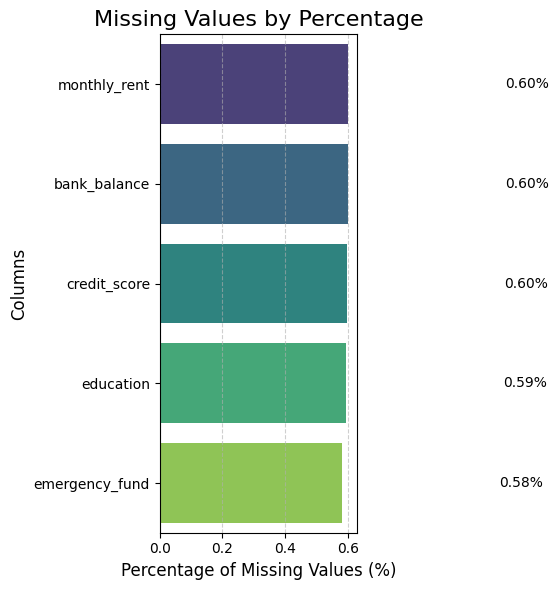

In [141]:
missing_percent = df_data.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if missing_percent.empty:
    print("✅ No missing values found in the dataset.")
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="viridis")

    plt.title("Missing Values by Percentage", fontsize=16)
    plt.xlabel("Percentage of Missing Values (%)", fontsize=12)
    plt.ylabel("Columns", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    for i, v in enumerate(missing_percent.values):
        plt.text(v + 0.5, i, f"{v:.2f}%", va='center')

    plt.tight_layout()
    plt.show()

###Eliminating Missing Values

In [142]:
df_data.dropna(inplace=True)
df_data

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27.0,Male,Married,Graduate,32400.0,Private,5.0,Large Indian,Rented,10400.0,...,No,0.0,649.0,62000.0,32600.0,Personal Loan EMI,506000.0,47,Not_Eligible,500.0
404796,38.0,Male,Married,Post Graduate,49200.0,Private,1.9,MNC,Own,0.0,...,No,0.0,712.0,142200.0,38100.0,Personal Loan EMI,708000.0,33,Not_Eligible,5200.0
404797,32.0,Male,Single,Graduate,25700.0,Private,3.2,MNC,Rented,6300.0,...,No,0.0,676.0,191600.0,39700.0,Home Appliances EMI,93000.0,21,High_Risk,5665.0
404798,48.0,Male,Married,Graduate,47200.0,Private,3.0,MNC,Own,0.0,...,No,0.0,784.0,170400.0,45600.0,Home Appliances EMI,144000.0,36,Eligible,14460.0


In [143]:
df_data.isna().sum()

,0
age,0
gender,0
marital_status,0
education,0
monthly_salary,0
employment_type,0
years_of_employment,0
company_type,0
house_type,0
monthly_rent,0


In [144]:
df_data.columns

Index(['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure', 'emi_eligibility',
       'max_monthly_emi'],
      dtype='object')

## Exploratory Data Analysis

### Distribution of numeric columns

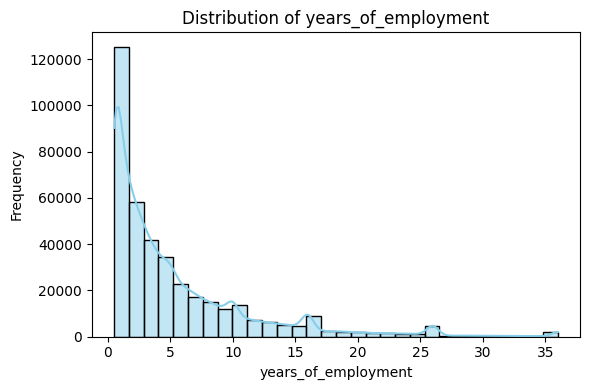

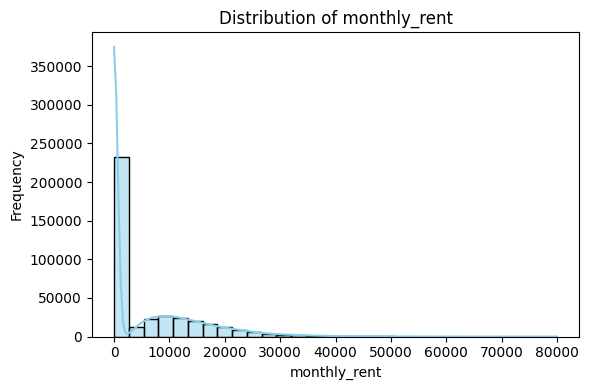

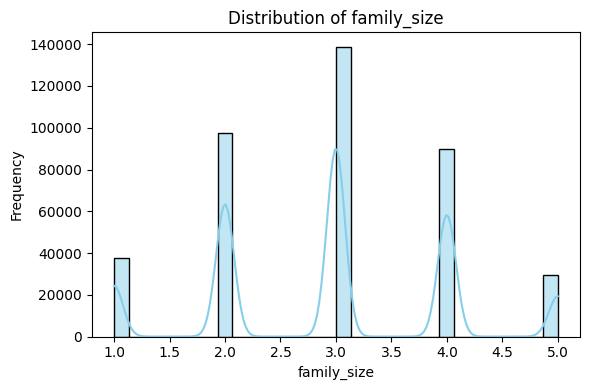

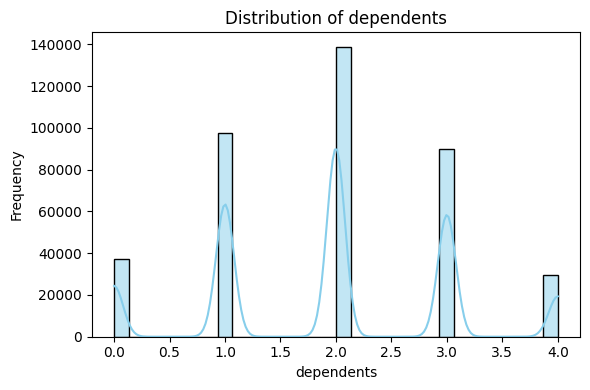

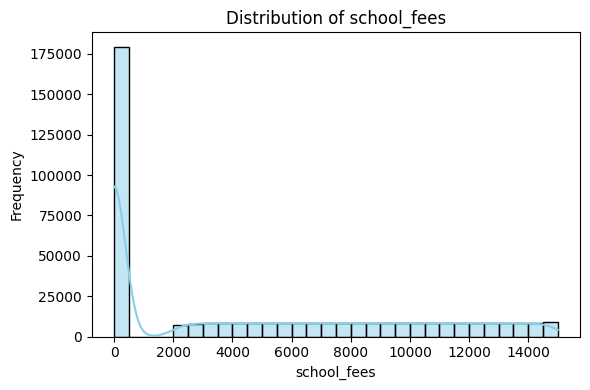

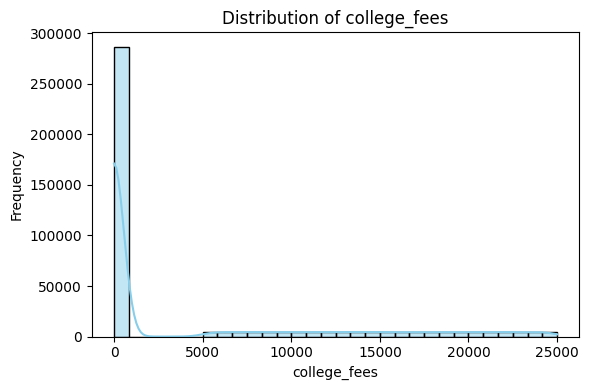

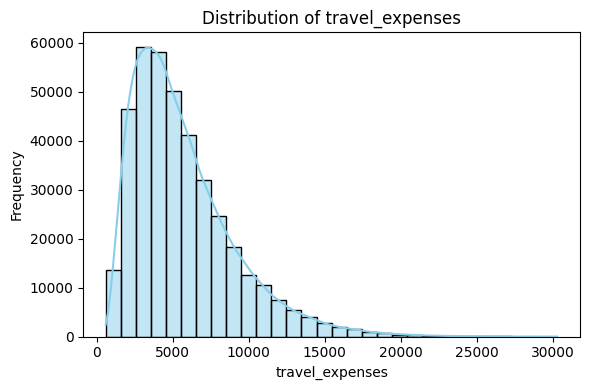

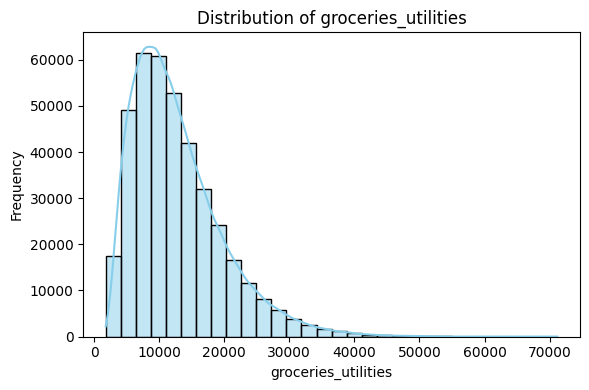

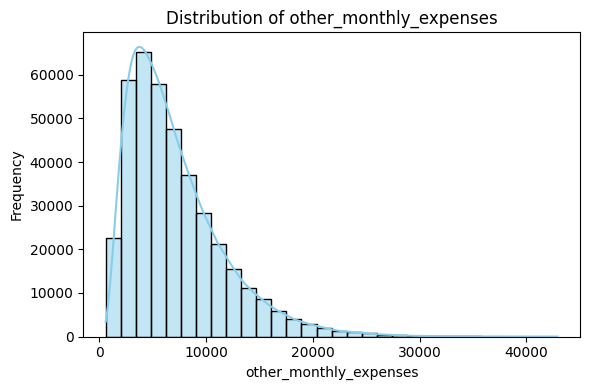

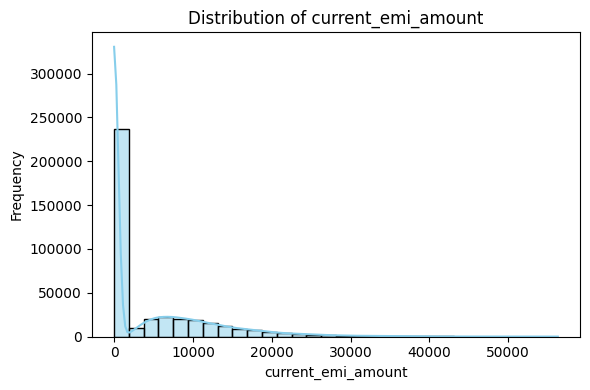

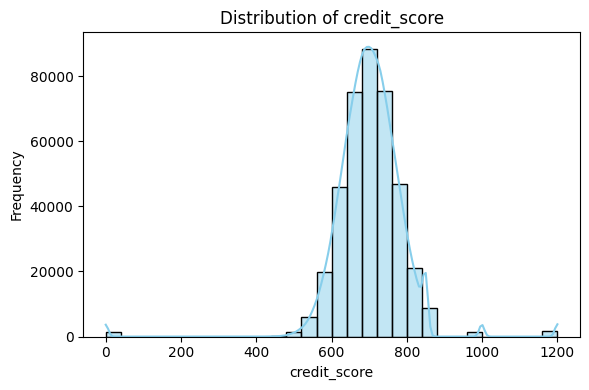

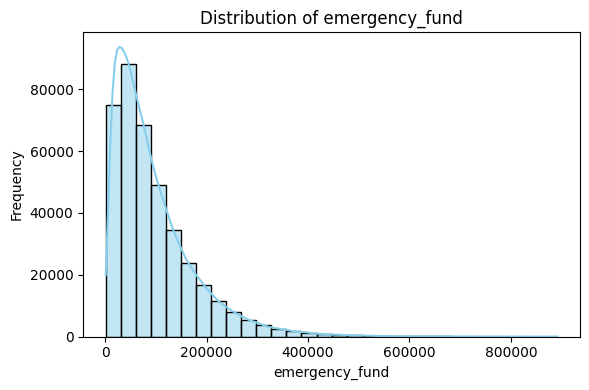

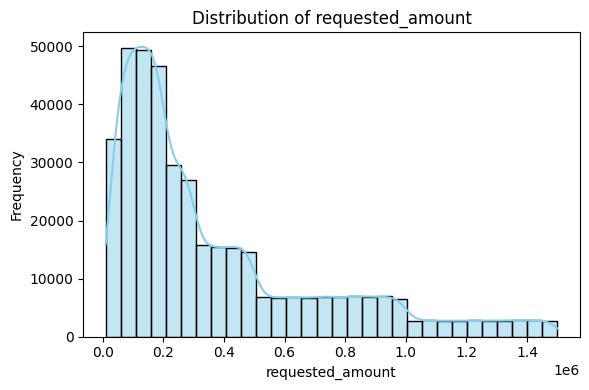

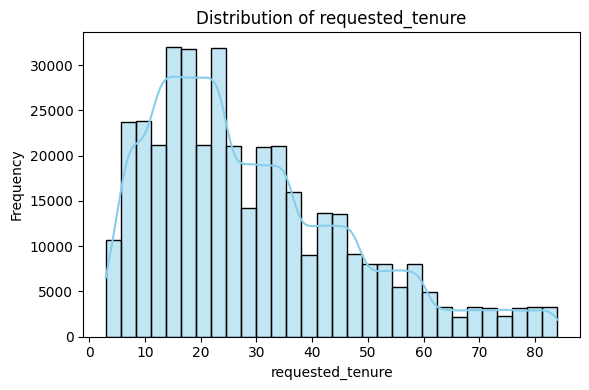

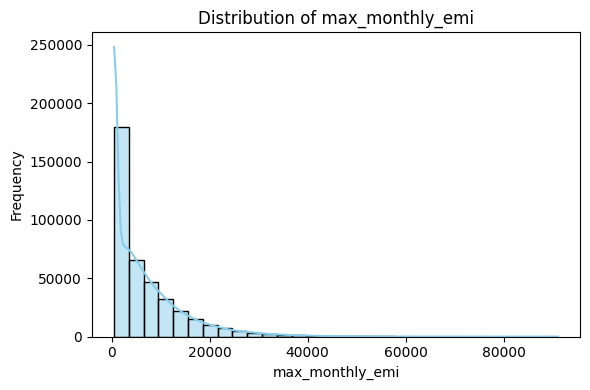

In [145]:
numeric_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_data[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Boxplot for Outliers**

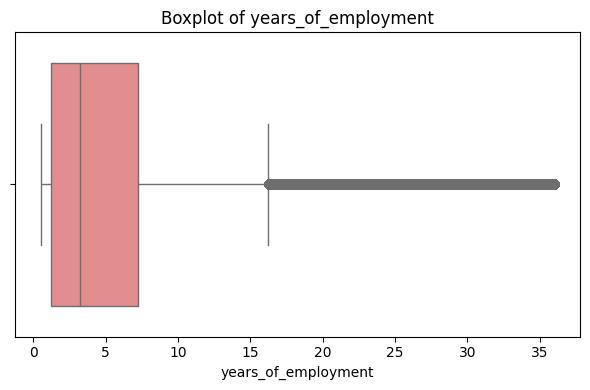

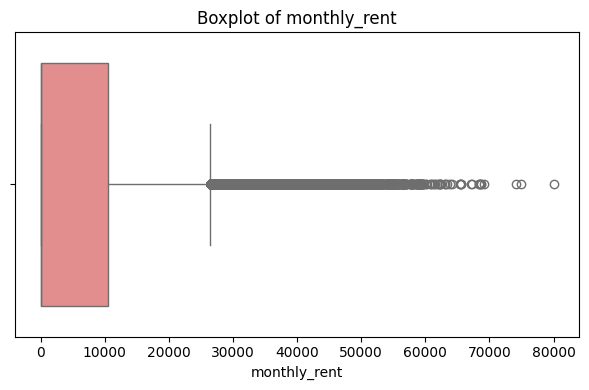

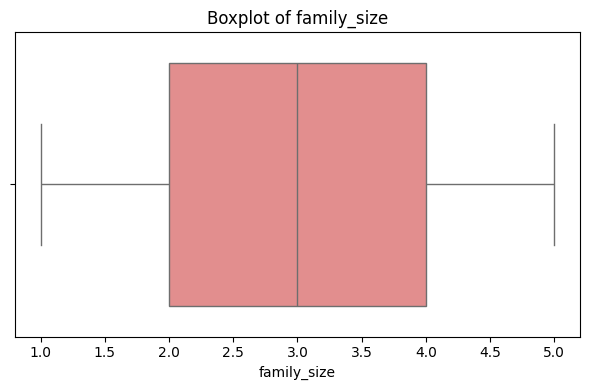

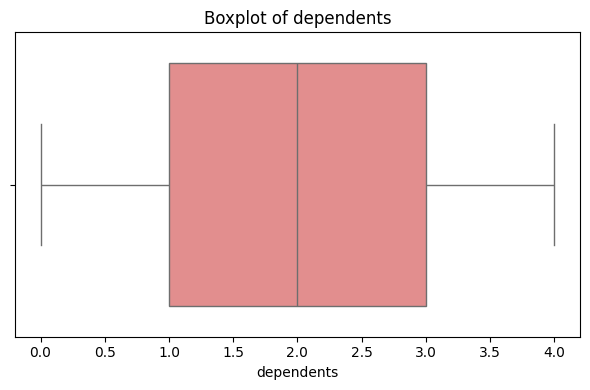

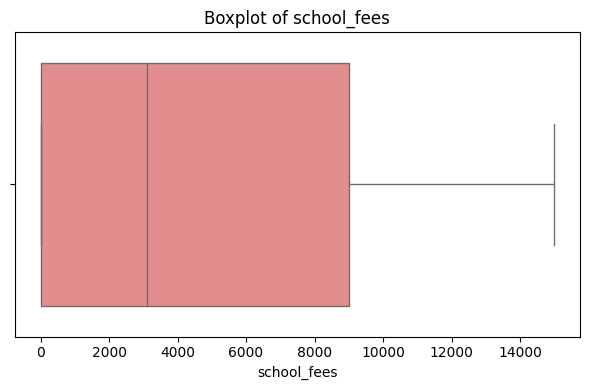

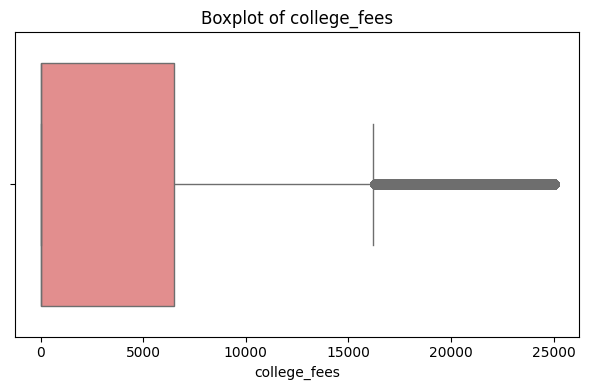

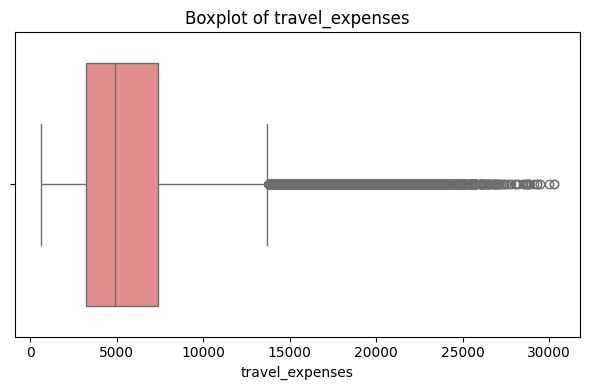

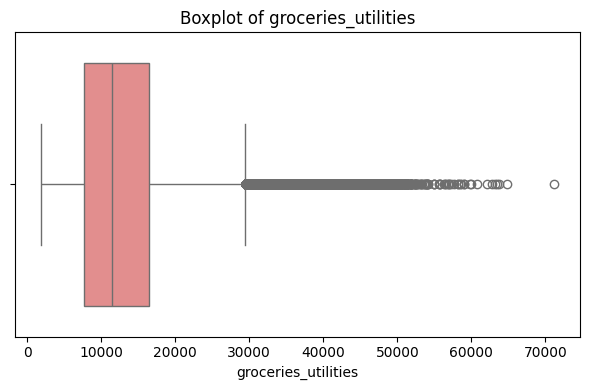

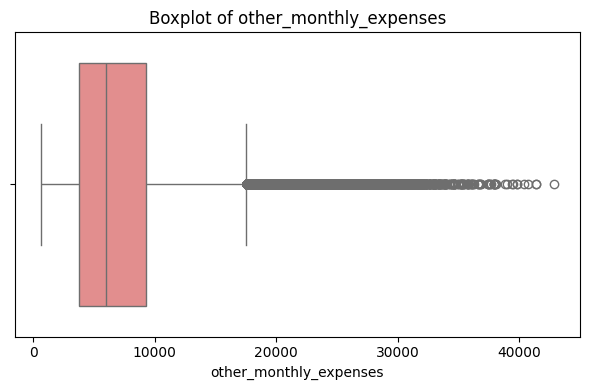

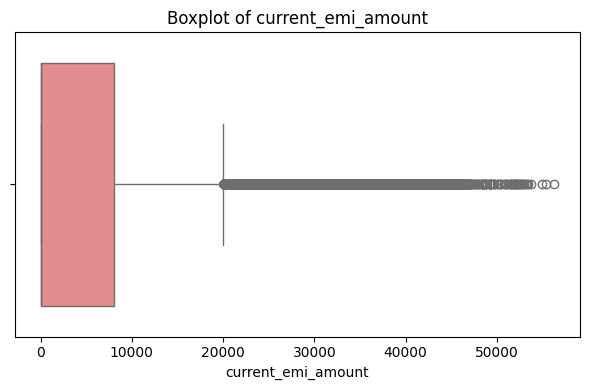

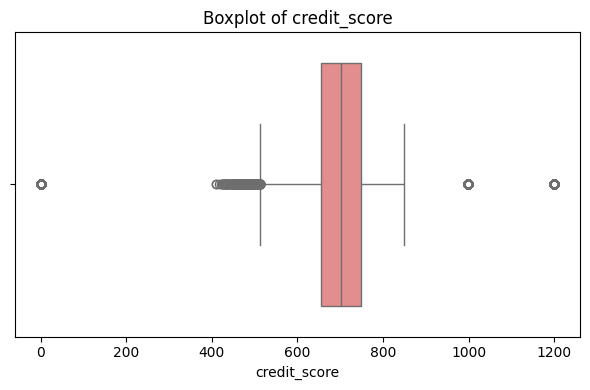

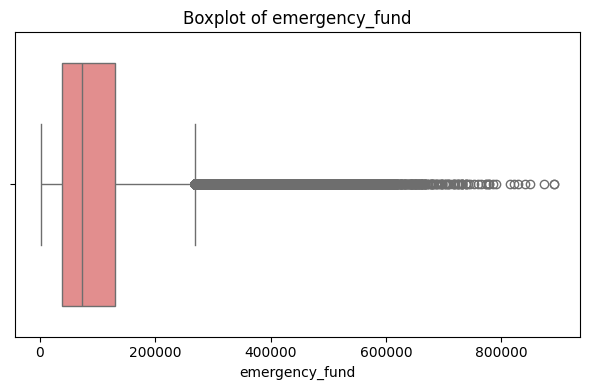

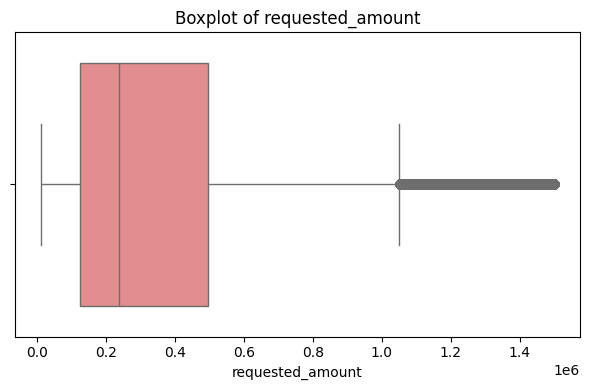

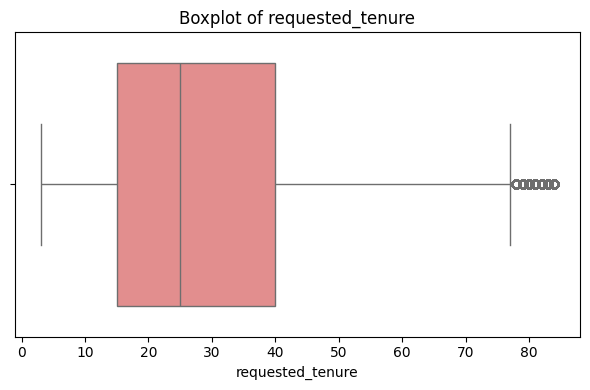

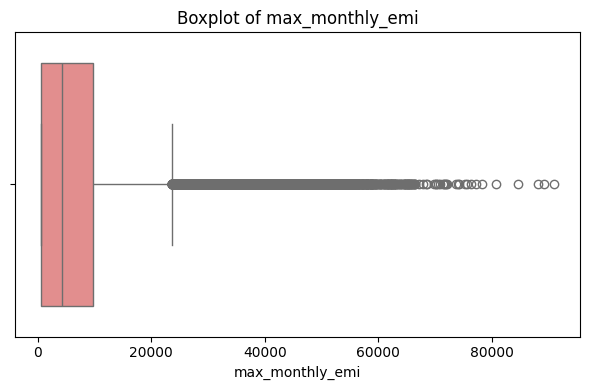

In [146]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_data[col], color='lightcoral')
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

**Gender based distribution**

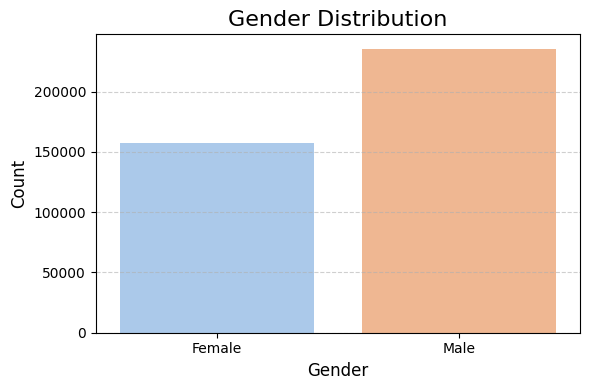

In [147]:
genders = {
    'Male': 'Male',
    'male': 'Male',
    'MALE': 'Male',
    'M': 'Male',
    'Female': 'Female',
    'female': 'Female',
    'FEMALE': 'Female',
    'F': 'Female',
}

df_data['gender'] = df_data['gender'].map(genders)

plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df_data, palette='pastel')

plt.title("Gender Distribution", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Credit Score Distribution by Employment type**

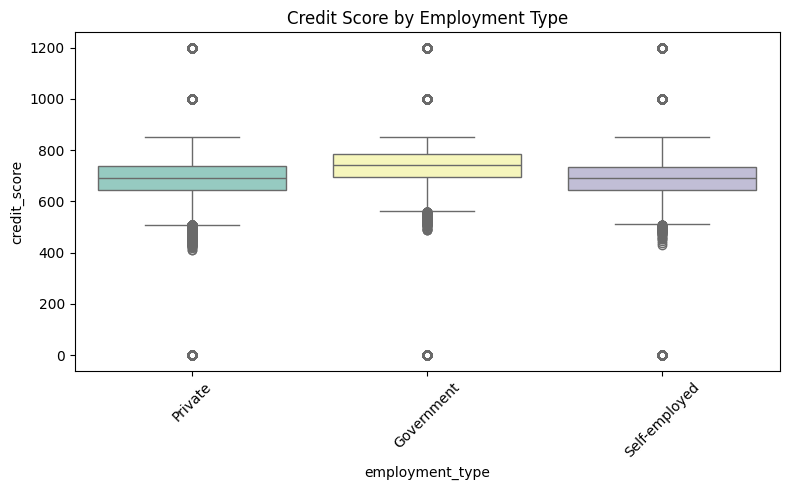

In [148]:
if 'credit_score' in df_data.columns and 'employment_type' in df_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='employment_type', y='credit_score', data=df_data, palette='Set3')
    plt.title("Credit Score by Employment Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Relationship between requested amount & salary**

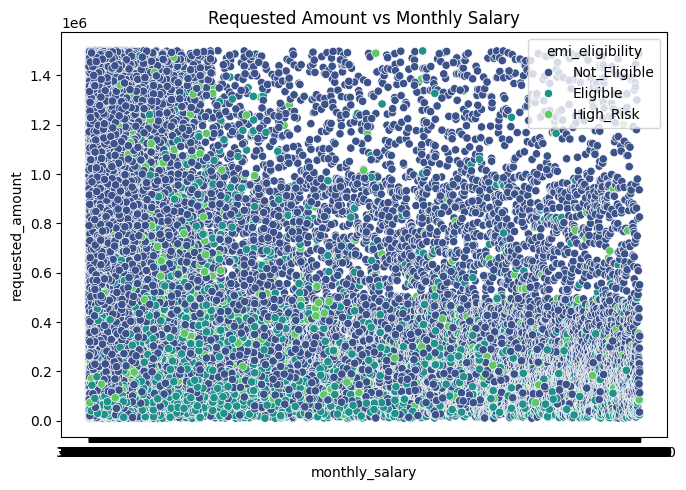

In [149]:
if {'requested_amount', 'monthly_salary'}.issubset(df_data.columns):
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x='monthly_salary', y='requested_amount', hue='emi_eligibility', data=df_data, palette='viridis')
    plt.title("Requested Amount vs Monthly Salary")
    plt.tight_layout()
    plt.show()

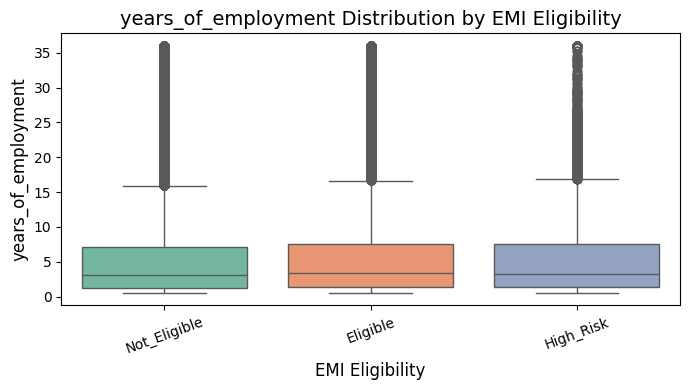

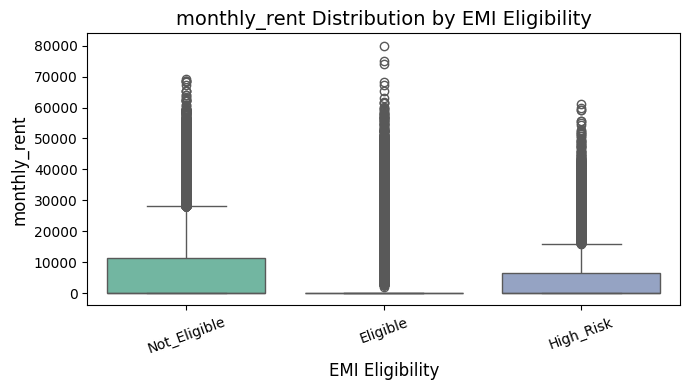

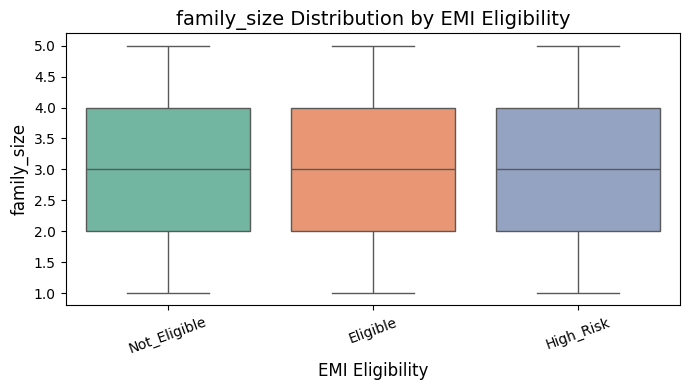

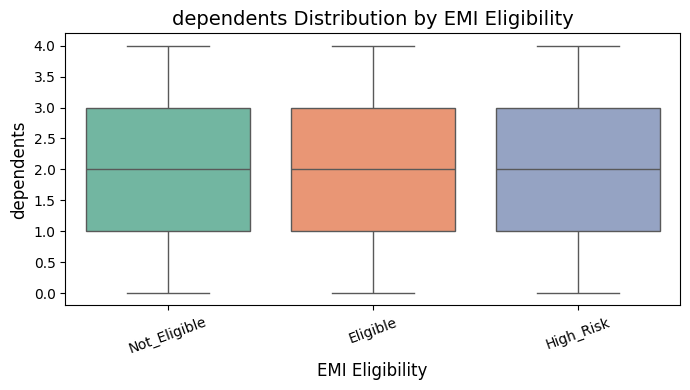

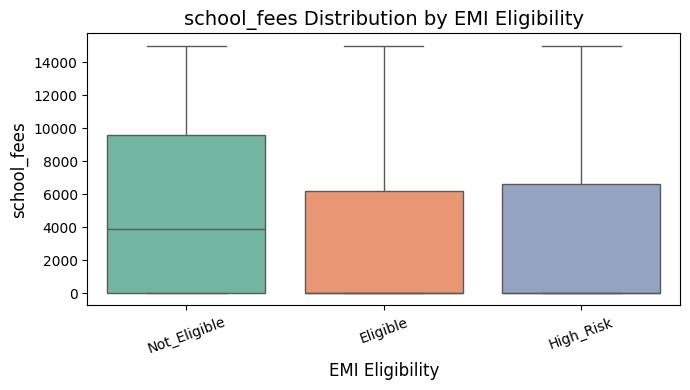

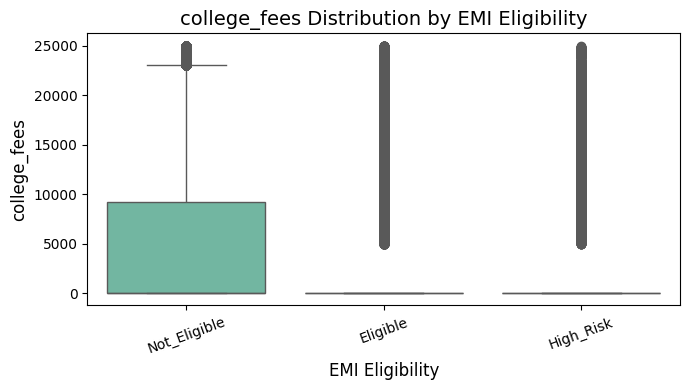

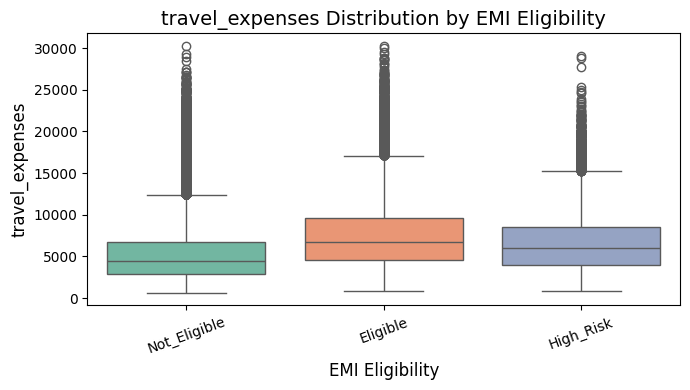

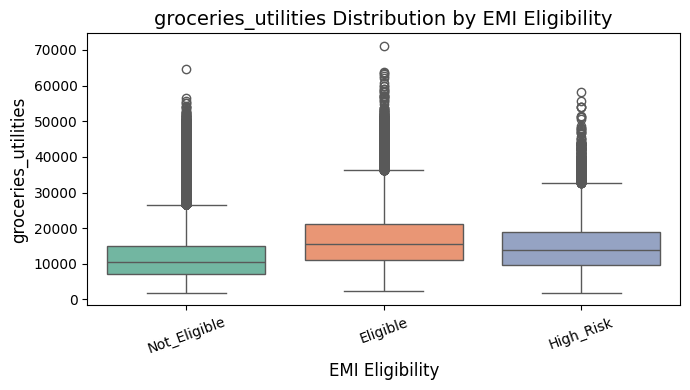

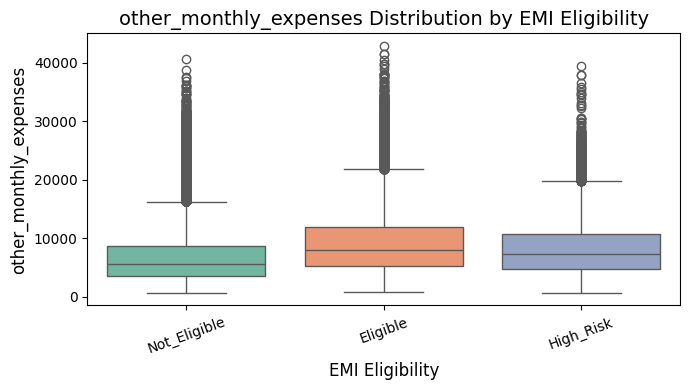

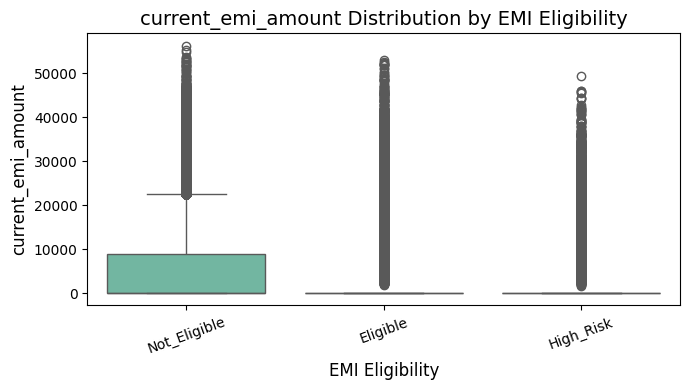

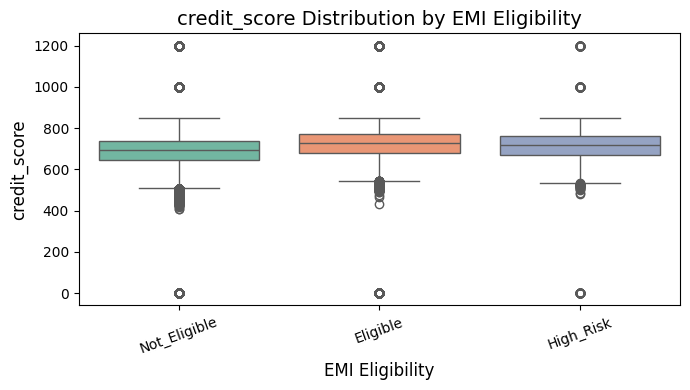

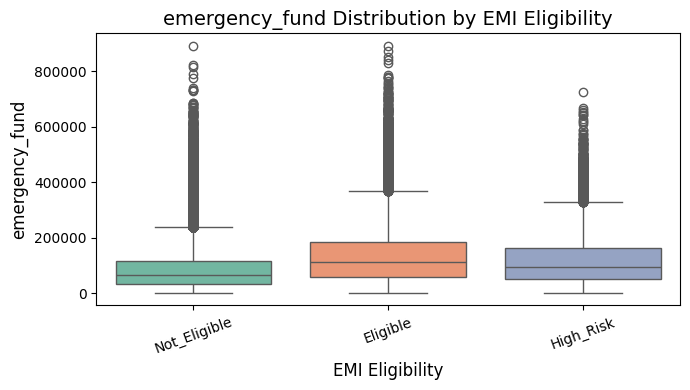

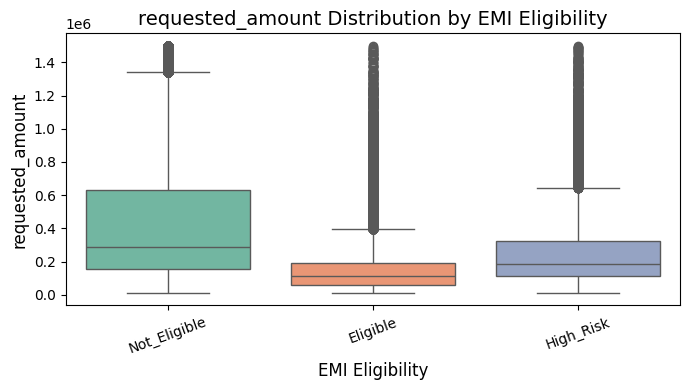

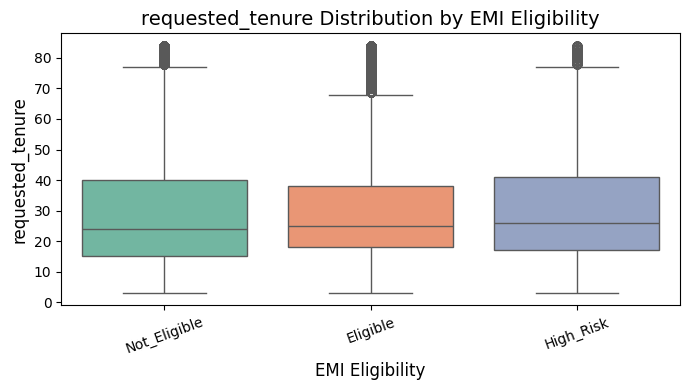

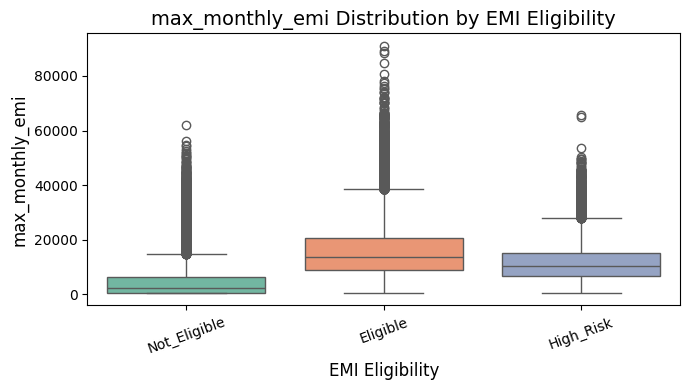

In [150]:
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='emi_eligibility', y=col, data=df_data, palette='Set2')
    plt.title(f"{col} Distribution by EMI Eligibility", fontsize=14)
    plt.xlabel("EMI Eligibility", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

**Correlation Mapping**

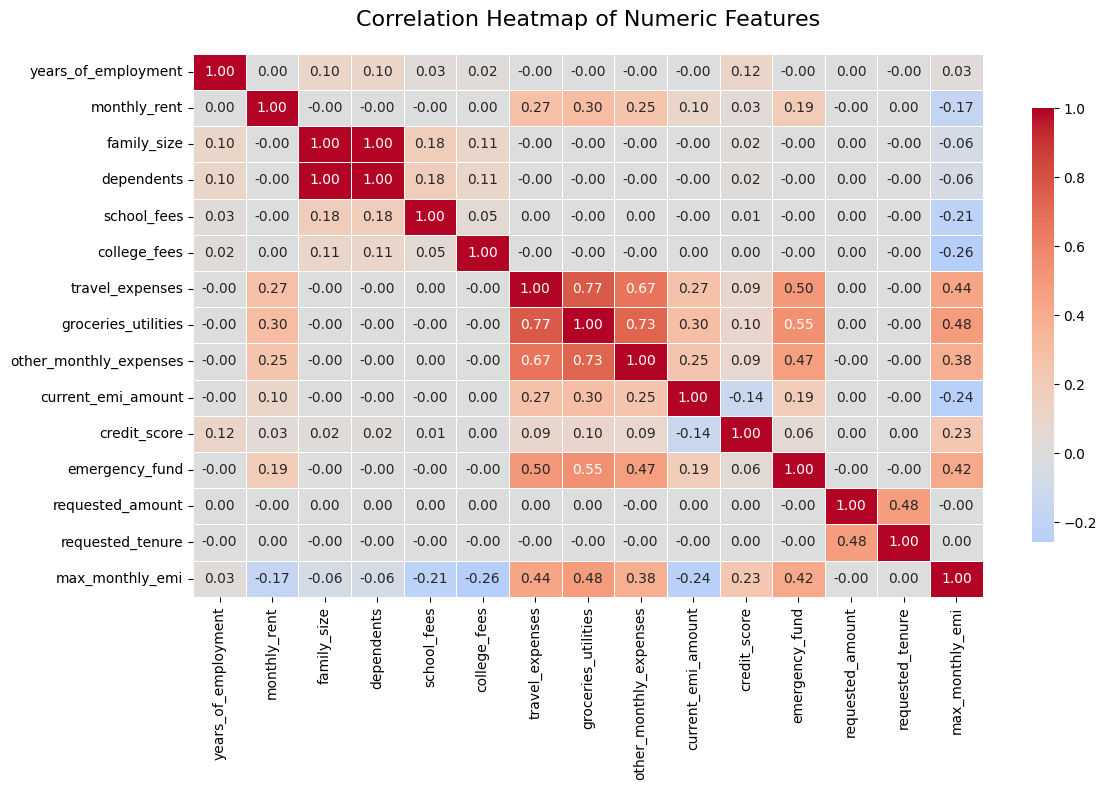

In [151]:
numeric_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

corr = df_data[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

###Model Building and Predicting

In [152]:
from sklearn.linear_model import LogisticRegression, LinearRegression

**EMI Eligibility**

In [153]:
X = df_data.drop(columns=['emi_eligibility'])
print("\nFeatures X:")
print(X.head())


Features X:
    age  gender marital_status     education monthly_salary employment_type  \
0  38.0  Female        Married  Professional        82600.0         Private   
1  38.0  Female        Married      Graduate        21500.0         Private   
2  38.0    Male        Married  Professional        86100.0         Private   
3  58.0  Female        Married   High School        66800.0         Private   
4  48.0  Female        Married  Professional        57300.0         Private   

   years_of_employment company_type house_type  monthly_rent  ...  \
0                  0.9     Mid-size     Rented       20000.0  ...   
1                  7.0          MNC     Family           0.0  ...   
2                  5.8      Startup        Own           0.0  ...   
3                  2.2     Mid-size        Own           0.0  ...   
4                  3.4     Mid-size     Family           0.0  ...   

   other_monthly_expenses  existing_loans  current_emi_amount  credit_score  \
0                 

In [154]:
y = df_data['emi_eligibility']
print("Target y:")
print(y.value_counts())

Target y:
emi_eligibility
Not_Eligible    303708
Eligible         72248
High_Risk        16964
Name: count, dtype: int64


In [155]:
categorical_cols = X.select_dtypes(include=['object']).columns

In [156]:
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [157]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [158]:
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

###Models

**Logistic Regression**

In [160]:
lgr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lgr_model.fit(X_train, y_train)
y_pred_lgr = lgr_model.predict(X_test)

In [161]:
y_pred_labels = le_y.inverse_transform(y_pred_lgr)
y_test_labels = le_y.inverse_transform(y_test)

In [162]:
print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print(classification_report(y_test_labels, y_pred_labels))


--- Logistic Regression ---
Accuracy: 0.9204672706912349
              precision    recall  f1-score   support

    Eligible       0.84      0.89      0.86     14450
   High_Risk       0.35      0.04      0.07      3393
Not_Eligible       0.94      0.98      0.96     60741

    accuracy                           0.92     78584
   macro avg       0.71      0.63      0.63     78584
weighted avg       0.90      0.92      0.90     78584



**Random Forest Classifier**

In [163]:
rfc_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rfc_model.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)

In [164]:
y_pred_labels = le_y.inverse_transform(y_pred_rfc)
y_test_labels = le_y.inverse_transform(y_test)

In [165]:
print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print(classification_report(y_test_labels, y_pred_labels))


--- Random Forest ---
Accuracy: 0.9561488343683192
              precision    recall  f1-score   support

    Eligible       0.92      0.98      0.95     14450
   High_Risk       0.88      0.09      0.16      3393
Not_Eligible       0.97      1.00      0.98     60741

    accuracy                           0.96     78584
   macro avg       0.92      0.69      0.70     78584
weighted avg       0.95      0.96      0.94     78584



**XGBoost Classifier**

In [166]:
import xgboost as xgb

In [167]:
xgbc_model = xgb.XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5,
    objective='multi:softmax', num_class=len(np.unique(y_encoded)),
    random_state=42
)
xgbc_model.fit(X_train, y_train)
y_pred_xgbc = xgbc_model.predict(X_test)

In [168]:
y_pred_labels = le_y.inverse_transform(y_pred_xgbc)
y_test_labels = le_y.inverse_transform(y_test)

In [169]:
print("\n--- XGBoost ---")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print(classification_report(y_test_labels, y_pred_labels))


--- XGBoost ---
Accuracy: 0.9828209304693067
              precision    recall  f1-score   support

    Eligible       0.96      0.99      0.98     14450
   High_Risk       0.93      0.66      0.77      3393
Not_Eligible       0.99      1.00      0.99     60741

    accuracy                           0.98     78584
   macro avg       0.96      0.88      0.91     78584
weighted avg       0.98      0.98      0.98     78584



Saving Classification Models

In [170]:
joblib.dump(lgr_model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [171]:
joblib.dump(rfc_model, 'random_forest_classifier_model.pkl')

['random_forest_classifier_model.pkl']

In [172]:
joblib.dump(xgbc_model, 'xgboost_classifier_model.pkl')

['xgboost_classifier_model.pkl']

**Max Monthly EMI**

In [173]:
X = df_data.drop(columns=['max_monthly_emi'])
print("\nFeatures X:")
print(X.head())


Features X:
    age  gender marital_status     education monthly_salary employment_type  \
0  38.0  Female        Married  Professional        82600.0         Private   
1  38.0  Female        Married      Graduate        21500.0         Private   
2  38.0    Male        Married  Professional        86100.0         Private   
3  58.0  Female        Married   High School        66800.0         Private   
4  48.0  Female        Married  Professional        57300.0         Private   

   years_of_employment company_type house_type  monthly_rent  ...  \
0                  0.9     Mid-size     Rented       20000.0  ...   
1                  7.0          MNC     Family           0.0  ...   
2                  5.8      Startup        Own           0.0  ...   
3                  2.2     Mid-size        Own           0.0  ...   
4                  3.4     Mid-size     Family           0.0  ...   

   other_monthly_expenses  existing_loans  current_emi_amount  credit_score  \
0                 

In [174]:
y = df_data['max_monthly_emi']
print("Target y:")
print(y.head())

Target y:
0      500.0
1      700.0
2    27775.0
3    16170.0
4      500.0
Name: max_monthly_emi, dtype: float64


In [175]:
categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [176]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [177]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [178]:
from sklearn.metrics import mean_squared_error, r2_score

**Linear Regression**

In [179]:
lnr_model = LinearRegression()
lnr_model.fit(X_train, y_train)
y_pred_lnr = lnr_model.predict(X_test)

In [180]:
r2_lnr = r2_score(y_test, y_pred_lnr)
rmse_lnr = np.sqrt(mean_squared_error(y_test, y_pred_lnr))

In [181]:
print("\n--- Linear Regression ---")
print("R2 Score:", r2_lnr)
print("RMSE:", rmse_lnr)


--- Linear Regression ---
R2 Score: 0.7357234966919258
RMSE: 4002.581028872417


**Random Forest Regressor**

In [182]:
rfr_model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rfr_model.fit(X_train, y_train)
y_pred_rfr = rfr_model.predict(X_test)

In [183]:
r2_rfr = r2_score(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))

In [184]:
print("R2 Score:", r2_score(y_test, y_pred_rfr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rfr)))

R2 Score: 0.9592211676743332
RMSE: 1572.274060942718


**XGBoost Regressor**

In [185]:
xgbr_model = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=5, n_jobs=-1, random_state=42
)
xgbr_model.fit(X_train, y_train)
y_pred_xgbr = xgbr_model.predict(X_test)

In [186]:
r2_xgbr = r2_score(y_test, y_pred_xgbr)
rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_pred_xgbr))

In [187]:
print("R2 Score:", r2_score(y_test, y_pred_xgbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgbr)))

R2 Score: 0.9584711812784172
RMSE: 1586.666475112919


**LGBM Regressor**

In [188]:
lgbr_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    n_jobs=-1,
    random_state=42
)
lgbr_model.fit(X_train, y_train)
y_pred_lgbr = lgbr_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 314336, number of used features: 26
[LightGBM] [Info] Start training from score 6764.835170


In [189]:
r2_lgbr = r2_score(y_test, y_pred_lgbr)
rmse_lgbr = np.sqrt(mean_squared_error(y_test, y_pred_lgbr))

In [190]:
print("\n--- LightGBM Regressor ---")
print("R2 Score:", r2_lgbr)
print("RMSE:", rmse_lgbr)


--- LightGBM Regressor ---
R2 Score: 0.9607974142494528
RMSE: 1541.587617799313


Saving Regression Models

In [191]:
joblib.dump(lnr_model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [192]:
joblib.dump(rfr_model, 'random_forest_regressor_model.pkl')

['random_forest_regressor_model.pkl']

In [193]:
joblib.dump(xgbr_model, 'xgboost_regressor_model.pkl')

['xgboost_regressor_model.pkl']

In [194]:
joblib.dump(lgbr_model, 'lgbm_regressor_model.pkl')

['lgbm_regressor_model.pkl']